#### Student Name:
#### Student ID:

# Assignment 4

### Markov Chain, LZify

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF and a WAV file of your Fur Elise variation.

* Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0. 

## Markov-Based Chord Prediction

In music, certain chord transitions are more likely than others. This idea can be applied as Markov Models, where the first-order temporal relationships between the various chords are captured by the transition probability matrix $A$. 

If we consider only major and minor chords, there are a total of 24 chords in this model (12 major, from C through B, and 12 minor, from C through B), formalized as:

\begin{equation}
\label{eq:ChordReco:HMM:App:Spec:SetStates}
  \mathcal{A} = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{Cm^\sharp},\ldots,\mathbf{Bm}\} 
\end{equation}

We use the notation $\alpha{i}\rightarrow\alpha{j}$ referring to the transition from state $\alpha{i}$ to state $\alpha{j}$, $i,j\in[1:24]$. For example, the coefficient $a_{1,2}$ expresses the 
probability for the transition $\alpha_{1}\rightarrow\alpha_{2}$ (corresponding to  $\mathbf{C}\rightarrow\mathbf{C}^\sharp$), whereas $a_{1,8}$ expresses the probability for $\alpha_{1}\rightarrow\alpha_{8}$  (corresponding to  $\mathbf{C}\rightarrow\mathbf{G}$). In real music, the change from a tonic to the dominant is much more likely
than transposing by one semitone, so that the probability $a_{1,8}$ should be much larger than $a_{1,2}$. The coefficients $a_{i,i}$ express the probability of staying in state $\alpha_{i}$ (i.e., $\alpha_{i}\rightarrow\alpha_{i}$), $i\in[1:24]$. These coefficients are also referred to as **self-transition** probabilities.

A transition probability matrix can be specified in many ways. For example, the matrix may be defined manually by a music expert based on rules from harmony theory. The most common approach is to generate such a matrix automatically 
by estimating the transition probabilities from labeled data. 

In the following exercise, you will create a Markov model by determining transition probabilities found in the music of the Beatles using bigrams (pairs of adjacent elements) in labeled frame sequences from a subset of the Beatles Corpus.

For this assignment, assume each row in the dataset represents a chord that has followed the chord on the previous row in a Beatles song. When parsing the file for your model, you may discard any chord references beyond key and major/minor quality. For example, if a row reads 'Bbm7', you would parse for the key (B-flat) and quality (minor), but discard the extra information that it is a 7th chord.  

In [1]:
!{__import__('sys').executable} -m pip install --quiet numpy pandas scipy librosa matplotlib music21 jchord mido

import numpy as np
import pandas as pd
from collections import Counter
from numpy.random import multinomial as randm
from numpy import where
import scipy.signal as si
import IPython.display as ipd
import librosa
import scipy
from matplotlib import patches
import librosa.display as ld
import music21
from music21 import midi as midi21
from music21 import stream
from jchord.progressions import ChordProgression, MidiConversionSettings
import copy
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

np.random.seed(42)

_data = pd.read_csv('Liverpool_band_chord_sequence.csv')

def preprocess(df):
    df = pd.DataFrame(df)
    df[df['chords'] == 'Bb'] = 'A#'  
    #chords = ' '.join(map(str, df['chords']))
    chords = df['chords']
    return chords

data = preprocess(_data)

def play(x):
    """Returns nothing. Outputs a midi realization of x, a note or stream.
    Primarily for use in notebooks and web environments.
    """
    prog = ChordProgression.from_string(x)
    print(prog.midi())
    prog.to_midi(MidiConversionSettings(filename="example.mid", tempo=100, beats_per_chord=4, instrument=4))
    mf = midi21.MidiFile()
    mf.open("example.mid")
    mf.read()
    mf.close()
    s = midi21.translate.midiFileToStream(mf)
    #myStream = stream.Stream()

    #myStream.append(s)
    #x = myStream
    x = s
    
    '''
    if isinstance(x, stream.Stream):
        x = copy.deepcopy(x)
        for subStream in x.recurse(streamsOnly=True, includeSelf=True):
            mss = subStream.getElementsByClass(stream.Measure)
            for ms in mss:
                ms.offset += 1.0
    if isinstance(x, music21.note.Note):
        s = stream.Stream()
        s.append(music21.note.Rest(1))
        s.append(x)
        x = s
    x.makeMeasures(inPlace = True)'''
    x.show('midi')
    return x

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


##### Question 1 (20 points)

Using the above data, generate a 24x24 matrix, where each matrix element (i,j) is the transition probability from chord i to chord j. 

In [2]:
#MM = np.zeros((24,24))

### Your code here: 
def transition_matrix(X, colname = None, rowname = None):
    return pd.crosstab(
        pd.Series(np.array(X[1:]), name = colname),
        pd.Series(np.array(X[:-1]), name = rowname), 
        normalize = 'columns'
    )

MM = transition_matrix(data)

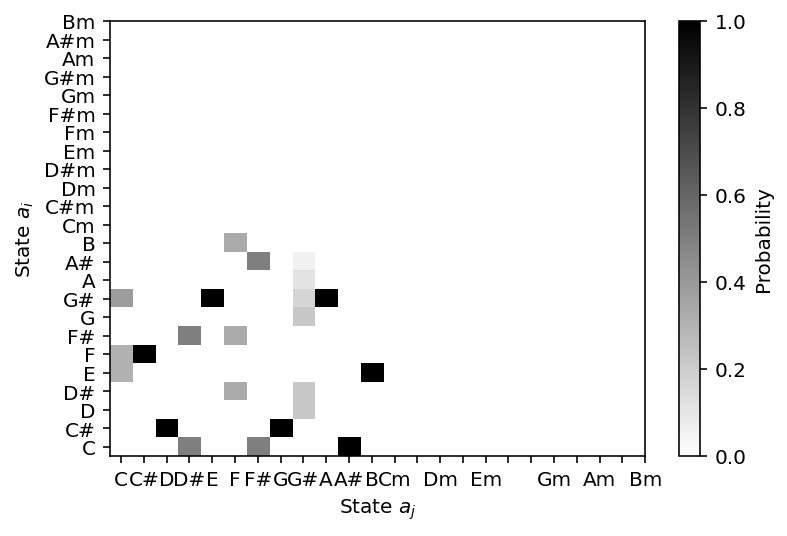

In [3]:
def plot_transition_matrix(A, ax=None, xlabel='State $a_j$', ylabel='State $a_i$', title='', clim=[-6, 0], cmap='gray_r'):
    
    im = plt.imshow(A, origin='lower', aspect='auto', cmap=cmap)
    im.set_clim([0, 1])
    cbar = plt.colorbar(im)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    cbar.ax.set_ylabel('Probability')
    
    chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_label_maj = chroma_label
    chord_label_min = [s + 'm' for s in chroma_label]
    chord_labels = chord_label_maj + chord_label_min
    chord_labels_squeezed = chord_labels.copy()
    for k in [13, 15, 17, 18, 20, 22]:
        chord_labels_squeezed[k] = ''
        
    plt.xticks(np.arange(24), labels=chord_labels_squeezed )
    plt.yticks(np.arange(24), labels=chord_labels)
    
    return im

plot_transition_matrix(MM)

##### Question 2 (10 points)

Using your MM, you will create your own 16-measure Beatles hits!
For your first song, beginning on C major, select each next chord by choosing the chord with the largest transition probability from the current chord.

Make sure your chord progression string is formatted like this: 'C Dm G C'

Otherwise, it may not play in the in-browser MIDI player. 

In [4]:
my_first_beatles_hit = ''

### Your code here:
def _chord_prog(chords, quarter_len = 4):
    def _impl(cp : ChordProgression):
        res = []
        for c in cp.midi():
            res.append(music21.chord.Chord(c, quarterLength = quarter_len))
        return res
    return _impl(ChordProgression.from_string(' '.join(chords)))

def _make_my_first_hit(chords : list, *args, **kwargs):
    s = stream.Stream()
    
    s.append([
        music21.instrument.ElectricPiano(),
        music21.tempo.MetronomeMark(100),
        music21.meter.TimeSignature('4/4')
    ])
    s.append(_chord_prog(chords, *args, **kwargs))
    s.makeNotation(inPlace = True)
    
    return s

##
def _repeat(i, fn, offset = 0):
    c = start_with
    res = []
    
    while ...:
        c = fn(c)
        try: 
            if res[offset] == c: break
        except IndexError: pass
        res.append(c)

    return res


def _sel_chords_v1(m, start_with, repeat_offset = 0):
    return _repeat(
        start_with, 
        fn = lambda x: m.loc[x].idxmax(), 
        offset = repeat_offset
    )

start_with = 'C'
my_first_beatles_hit = [start_with] + _sel_chords_v1(
    MM, 
    start_with = start_with, 
    repeat_offset = 1
)
s = _make_my_first_hit(
    my_first_beatles_hit, 
    quarter_len = 4
)

print(my_first_beatles_hit)
s.show('midi')
s.show('text')

['C', 'Dm', 'A7', 'A7sus4', 'F', 'C7', 'Gm6', 'Dm']


{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.ElectricPiano 'Electric Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=100>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C4 E4 G4>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord D4 F4 A4>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.chord.Chord A4 C#5 E5 G5>
{12.0} <music21.stream.Measure 4 offset=12.0>
    {0.0} <music21.chord.Chord A4 D5 E5 G5>
{16.0} <music21.stream.Measure 5 offset=16.0>
    {0.0} <music21.chord.Chord F4 A4 C5>
{20.0} <music21.stream.Measure 6 offset=20.0>
    {0.0} <music21.chord.Chord C4 E4 G4 B-4>
{24.0} <music21.stream.Measure 7 offset=24.0>
    {0.0} <music21.chord.Chord G4 B-4 D5 E5>
{28.0} <music21.stream.Measure 8 offset=28.0>
    {0.0} <music21.chord.Chord D4 F4 A4>
    {4.0} <music21.bar.Barline type=final>


##### Question 3 (10 points)

For your second song, beginning on C major, select each next chord at random according to the probabilities of your MM.
For example, if C major transitions to G major with probability .5, F major with probability .25, and D minor with probability .25, then your next chord should be selected randomly from (G, F, Dm) with probability of selection (.5, .25, .25) respectively. 

In [5]:
def _sel_chords_v2(m, start_with, repeat_offset = 0):
    return _repeat(
        start_with, 
        fn = lambda x: m.loc[x].sample(1, weights = m.loc[x]).index[0], 
        offset = repeat_offset
    )

start_with = 'C'
my_first_beatles_hit0 = [start_with] + _sel_chords_v2(
    MM, 
    start_with = start_with, 
    repeat_offset = 1
)
s0 = _make_my_first_hit(
    my_first_beatles_hit0, 
    quarter_len = 1
)

print(my_first_beatles_hit0)
s0.show('midi')
s0.show('text')

['C', 'Dm', 'A7', 'Em7', 'F', 'C7', 'A#', 'C', 'F', 'F', 'Fsus4', 'F', 'Fsus4', 'F', 'C7', 'A#', 'C', 'Dm']


{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.ElectricPiano 'Electric Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=100>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C4 E4 G4>
    {1.0} <music21.chord.Chord D4 F4 A4>
    {2.0} <music21.chord.Chord A4 C#5 E5 G5>
    {3.0} <music21.chord.Chord E4 G4 B4 D5>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord F4 A4 C5>
    {1.0} <music21.chord.Chord C4 E4 G4 B-4>
    {2.0} <music21.chord.Chord B-4 D5 F5>
    {3.0} <music21.chord.Chord C4 E4 G4>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.chord.Chord F4 A4 C5>
    {1.0} <music21.chord.Chord F4 A4 C5>
    {2.0} <music21.chord.Chord F4 B-4 C5>
    {3.0} <music21.chord.Chord F4 A4 C5>
{12.0} <music21.stream.Measure 4 offset=12.0>
    {0.0} <music21.chord.Chord F4 B-4 C5>
    {1.0} <music21.chord.Chord F4 A4 C5>
    {2.0} <music21.chord.Chord C4 E4 G4 

## LZify: Applying Universal Prediction to Musical Style

LZify was the first algorithmic learning method to create a style immitation from a dictionary of motifs of variable size. It is based on the Lempel-Ziv compression method. Because the viriable context (motif) size that is used for perdiction of the next note, the method became also know as Variable Memory Markov model. Strictly speaking, is not a correct term, but LZ prediciton is known to perform asymptotically as good as any finite Markov model, so the terminology is partially justified. 

In this section, you will implement the Incremental Parsing (IP) from the Lempel Ziv LZ78 method for creating a dictionary of motifs. These motifs are later used to generate new sequences resembling the input sequence.

Please read the algorithm in Assayag, Dubnov, and Delerue's "Guessing the Composer’s Mind" (available at https://pdfs.semanticscholar.org/0181/236e1b417c8dd5dddd1f919583893f7a9026.pdf). 

The IPMotif function should compute the motif dictionary discovered in the text. It uses Incremental Parsing method to parse the text into unseen motifs.

##### Question 4 (20 points)

In [6]:
def IPMotif(text):
    """Compute an associative dictionary (the motif dictionary)."""
    
    dictionary = {}
    
    ### Your Code Here:
    text = list(text)
    motif = ''
    
    while text:    
        motif += text.pop()
        if motif in dictionary:
            dictionary[motif] += 1
        else:
            dictionary[motif] = 1
            motif = ''
    
    return dictionary

The text below contains an excerpt of Beethoven's Fur Elise, written as MML (Music Macro Language). MML is used to represent musical melodies as text. 

You can read more about MML syntax here: https://en.wikipedia.org/wiki/Music_Macro_Language

You can play with MML in this webapp: https://firecomb.github.io/final%20project.html

Try playing the text below in the webapp to hear sample output. 

In [7]:
text = 'o6ed+ed+ec-dc>aceabeg+bb+e<ed+ed+ec-dc>aceabe<c>bab<cde>g<fed>f<edc>e<dc>be<eeed+ed+ec-dc>aceabeg+bb+e<ed+ed+ec-dc>aceabe<c>ba'
dict1 = IPMotif(text)
print(dict1)

{'a': 4, 'b': 4, '>': 6, 'c': 10, '<': 6, 'e': 14, 'ba': 1, 'ec': 2, 'a>': 1, 'cd': 4, '-': 2, 'ce': 3, '+': 3, 'd': 6, 'e+': 4, 'de': 3, '<e': 2, '+b': 1, 'b+': 1, 'g': 1, 'eb': 4, 'ae': 1, 'ca': 2, '>c': 3, 'd-': 1, 'ce+': 2, 'de+': 1, 'dee': 1, 'e<': 1, 'eb>': 1, 'cd<': 1, 'e>': 1, 'cde': 1, '<f': 1, '>d': 1, 'ef': 1, '<g': 1, '>e': 1, 'dc': 1, '<b': 1, 'ab': 1, '>c<': 1, 'eba': 2, 'eca': 1, '>cd': 1, '-c': 1, 'e+d': 3, 'e+de': 2, '<e+': 1, 'bb': 1, '+g': 1, 'ebae': 1, 'ca>': 1, 'cd-': 1, 'ce+d': 1, 'e+de6': 1, 'o': 1}


Next, implement the IPContinuation and Normalize functions. 
The IPContinuation function transforms the IPMotif dictionary into a tree-like representation to allow finding continuations for new  motifs. The Normalize function turns the counters in every element of the IPContinuation dictionary into probabilities. 

##### Question 5 (20 points)

In [8]:
def IPContinuation(dict1):
    """Compute continuation dictionary from a motif dictionary"""
    
    dict2 = {}

    ### Your Code Here: 
    for motif, counter in dict1.items():
        *W, k = motif
        W = ''.join(W)
        if W in dict2:
            dict2[W] += [(k, counter)]
        else:
            dict2[W] = [(k, counter)]
            pass
        pass
    
    dict2 = Normalize(dict2)
    return dict2

##### Question 6 (10 points)

In [9]:
def Normalize(dict2):
    """Turns the counters in every element of dict2 to probabilities"""
    
    ### Your Code Here:
    for motif, counters in dict2.items():
        df = pd.DataFrame.from_records(
            counters, 
            columns = ['motif', 'counters']
        )
        df['counters'] = df['counters'] / df['counters'].sum()
        dict2[motif] = type(counters)(df.to_records(index = False))

    return dict2

In [10]:
import pprint
dict2 = IPContinuation(dict1)
pprint.pprint(dict2)

{'': [('a', 0.07017544),
      ('b', 0.07017544),
      ('>', 0.10526316),
      ('c', 0.1754386),
      ('<', 0.10526316),
      ('e', 0.24561404),
      ('-', 0.03508772),
      ('+', 0.05263158),
      ('d', 0.10526316),
      ('g', 0.01754386),
      ('o', 0.01754386)],
 '+': [('b', 0.5), ('g', 0.5)],
 '-': [('c', 1.)],
 '<': [('e', 0.4), ('f', 0.2), ('g', 0.2), ('b', 0.2)],
 '<e': [('+', 1.)],
 '>': [('c', 0.6), ('d', 0.2), ('e', 0.2)],
 '>c': [('<', 0.5), ('d', 0.5)],
 'a': [('>', 0.33333333), ('e', 0.33333333), ('b', 0.33333333)],
 'b': [('a', 0.33333333), ('+', 0.33333333), ('b', 0.33333333)],
 'c': [('d', 0.44444444), ('e', 0.33333333), ('a', 0.22222222)],
 'ca': [('>', 1.)],
 'cd': [('<', 0.33333333), ('e', 0.33333333), ('-', 0.33333333)],
 'ce': [('+', 1.)],
 'ce+': [('d', 1.)],
 'd': [('e', 0.6), ('-', 0.2), ('c', 0.2)],
 'de': [('+', 0.5), ('e', 0.5)],
 'e': [('c', 0.15384615),
       ('+', 0.30769231),
       ('b', 0.30769231),
       ('<', 0.07692308),
       ('>', 0.076

Generting a new sequence is done by traversing the IPContinuation tree and selecting possible branches according to their weights. If motif is not found, its last symbol is removed and the process is repeated for a shorter motif.

In [11]:
def IPGenerate(n,dict2):
    p = 0
    out = ""
    for k in range(n):
        while True:
            context = out[-p:]
            if context in dict2:
                prob = [tup[1] for tup in dict2[context]]
                conti = where(randm(1,prob))[0][0]
                cont = dict2[context][conti][0]
                out = out + cont
                break
            else:
                p = p-1
    return out
out = IPGenerate(92,dict2)
print(out)

e+de6e+de6a>cd<gga>c<gce+de6<e+de6d-ce+de6<baebaefe<e+de6ca>eb>ebae+de6<e+de6dce+de6aefce+de


##### Question 7 (10 points)

Paste your output in the online MML player, and listen to your piece. Do you hear elements of Fur Elise in your composition? What are some of the differences in the output from the original? 

Please export the WAV file of your output from the webapp, and submit the WAV file with your assignment. 

``` Your response here ```

Yes. Fur Elise is a classical masterpiece; The auto generated one, however, is very unfortunately not.

In [12]:
!{__import__('sys').executable} -m pip install --quiet quickjs requests

import quickjs
import requests

synthesisjs = requests.get(
    'https://framesynthesis.com/experiments/synthesis.js/build/synthesis.js'
).text

_mml2smf = quickjs.Function(
    'f', synthesisjs + '''
        function f(mml) {
            return synthesisjs.mml2smf(mml);
        }
    '''
)

def _mml_stream(mml : str):
    mf = midi21.MidiFile()
    mf.readstr(bytearray(pd.Series(_mml2smf(mml))))
    return midi21.translate.midiFileToStream(mf)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [13]:
s_orig = _mml_stream(text)

s_orig.show('midi')

In [14]:
s = _mml_stream(out)

s.show('midi')
s.show('text')

s.write('midi', fp = 'fur_elise_regenerated.mid')

{0.0} <music21.stream.Part 0x7fdad0834eb0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note F>
        {0.75} <music21.note.Rest 16th>
        {1.0} <music21.note.Note D>
        {1.75} <music21.note.Rest 16th>
        {2.0} <music21.note.Note E>
        {2.3333} <music21.note.Rest 1/3ql>
        {2.6667} <music21.note.Note F>
        {3.4167} <music21.note.Rest 16th>
        {3.6667} <music21.note.Note D>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note D>
        {0.4167} <music21.note.Rest 16th>
        {0.6667} <music21.note.Note E>
        {1.0} <music21.note.Rest 1/3ql>
        {1.3333} <music21.note.Note A>
        {2.0833} <music21.note.Rest 16th>
        {2.3333} <music21.note.Note C>
        {3.0833} <music21.note.Rest 16th>
        {3.3333} <music21.note.Note D>
    {8.0} <music21.stream.Measure 3 offset=8.0>
        {0.0} <m

'fur_elise_regenerated.mid'

A few important points:
1. The method captures the "texture" of the language but not it's meaning.
2. We could parse a new text using IPMotifs from two languages, then count the length and number of motifs in order to decide what was the language of the new text.
3. In order to use this method with musical information, we need first to translate audio to features, or in case of polyphonic midi change this into some proper representation. One possibility is using virtual fundamental or chroma for harmony, or some other specialized representation to capture repetition in terms of other specific musical properties.